Welcome to the 2023 edition of Kaggle's Playground Series!
Thank you to everyone who participated in and contributed to Season 3 Playground Series so far!

With the same goal to give the Kaggle community a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science, we will continue launching the Tabular Tuesday in May every Tuesday 00:00 UTC, with each competition running for 2 weeks. Again, these will be fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

Synthetically-Generated Datasets
Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!



In [65]:

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from itertools import product
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


Getting the train data using pandas

In [66]:

train = pd.read_csv('/content/train.csv',index_col="id").reset_index(drop=True)
train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


# **Normal EDA**

Train data info

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

Gives the full summary of train data

In [68]:
train.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


Gettng the data types

In [69]:
train.dtypes

clonesize               float64
honeybee                float64
bumbles                 float64
andrena                 float64
osmia                   float64
MaxOfUpperTRange        float64
MinOfUpperTRange        float64
AverageOfUpperTRange    float64
MaxOfLowerTRange        float64
MinOfLowerTRange        float64
AverageOfLowerTRange    float64
RainingDays             float64
AverageRainingDays      float64
fruitset                float64
fruitmass               float64
seeds                   float64
yield                   float64
dtype: object

To see if there are any duplicated values are present or not

In [70]:
train.duplicated().sum()

7

Correlation matrix

In [71]:
train.corr()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
clonesize,1.000000,0.304130,0.080433,0.065131,-0.007607,0.016159,0.015838,0.016057,0.016343,0.016026,0.015987,0.165770,0.164823,-0.406793,-0.377688,-0.396898,-0.382619
honeybee,0.304130,1.000000,-0.017937,0.030671,-0.010394,0.005840,0.005755,0.005892,0.005942,0.005809,0.005485,0.046494,0.037532,-0.120492,-0.135310,-0.139261,-0.118001
bumbles,0.080433,-0.017937,1.000000,-0.164962,0.158001,-0.002104,-0.001813,-0.001769,-0.001613,-0.001804,-0.001644,-0.063294,-0.060232,0.160447,0.163987,0.177022,0.161145
andrena,0.065131,0.030671,-0.164962,1.000000,0.309556,-0.013061,-0.012928,-0.012993,-0.012924,-0.013035,-0.013071,-0.026572,-0.027193,0.073669,0.064722,0.063504,0.073969
osmia,-0.007607,-0.010394,0.158001,0.309556,1.000000,-0.031391,-0.030819,-0.031415,-0.031398,-0.031486,-0.031337,-0.079874,-0.078720,0.209495,0.192210,0.200597,0.198264
MaxOfUpperTRange,0.016159,0.005840,-0.002104,-0.013061,-0.031391,1.000000,0.998599,0.999806,0.999503,0.999829,0.999772,0.011322,0.010352,0.007580,0.146237,0.060963,-0.022517
MinOfUpperTRange,0.015838,0.005755,-0.001813,-0.012928,-0.030819,0.998599,1.000000,0.999004,0.998199,0.998953,0.999040,0.011727,0.010767,0.008409,0.147203,0.061812,-0.021929
AverageOfUpperTRange,0.016057,0.005892,-0.001769,-0.012993,-0.031415,0.999806,0.999004,1.000000,0.999465,0.999973,0.999974,0.011245,0.010260,0.008503,0.147676,0.062082,-0.021940
MaxOfLowerTRange,0.016343,0.005942,-0.001613,-0.012924,-0.031398,0.999503,0.998199,0.999465,1.000000,0.999489,0.999423,0.011302,0.010262,0.007902,0.146668,0.061378,-0.022197
MinOfLowerTRange,0.016026,0.005809,-0.001804,-0.013035,-0.031486,0.999829,0.998953,0.999973,0.999489,1.000000,0.999963,0.011466,0.010479,0.007909,0.146704,0.061360,-0.022319


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

shape of the data

In [73]:
train.shape

(15289, 17)

checking the null values are present or not

In [74]:
train.isnull().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

There are no null values are present which is good for us.

Scatter Plot between Yield and Seeds

<Axes: xlabel='yield', ylabel='seeds'>

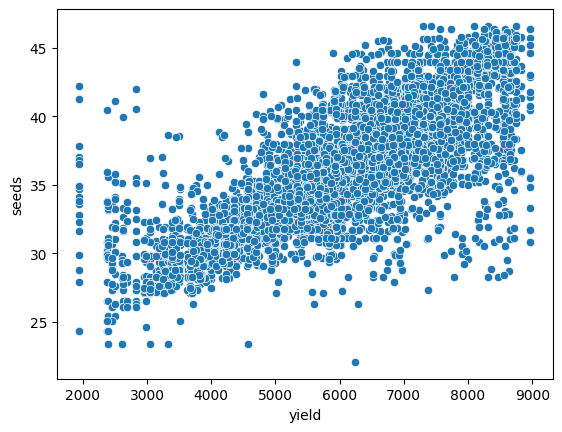

In [75]:
sns.scatterplot(x = 'yield',y = 'seeds',data = train)

Countplot for yield

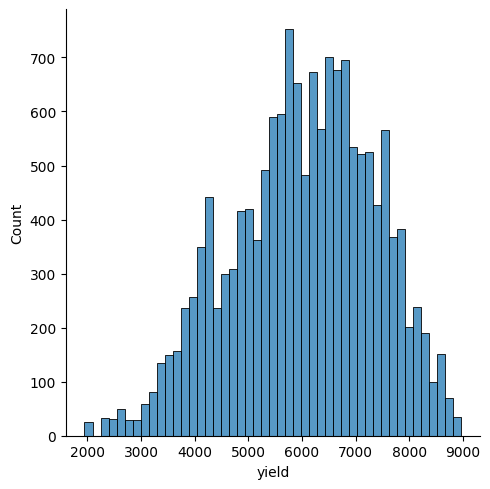

In [76]:
sns.displot(train, x="yield")

Getting the test data

In [77]:
df2 = pd.read_csv('/content/test.csv')
df2.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [78]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove('id')

Ploting the distributions of test and train variables.

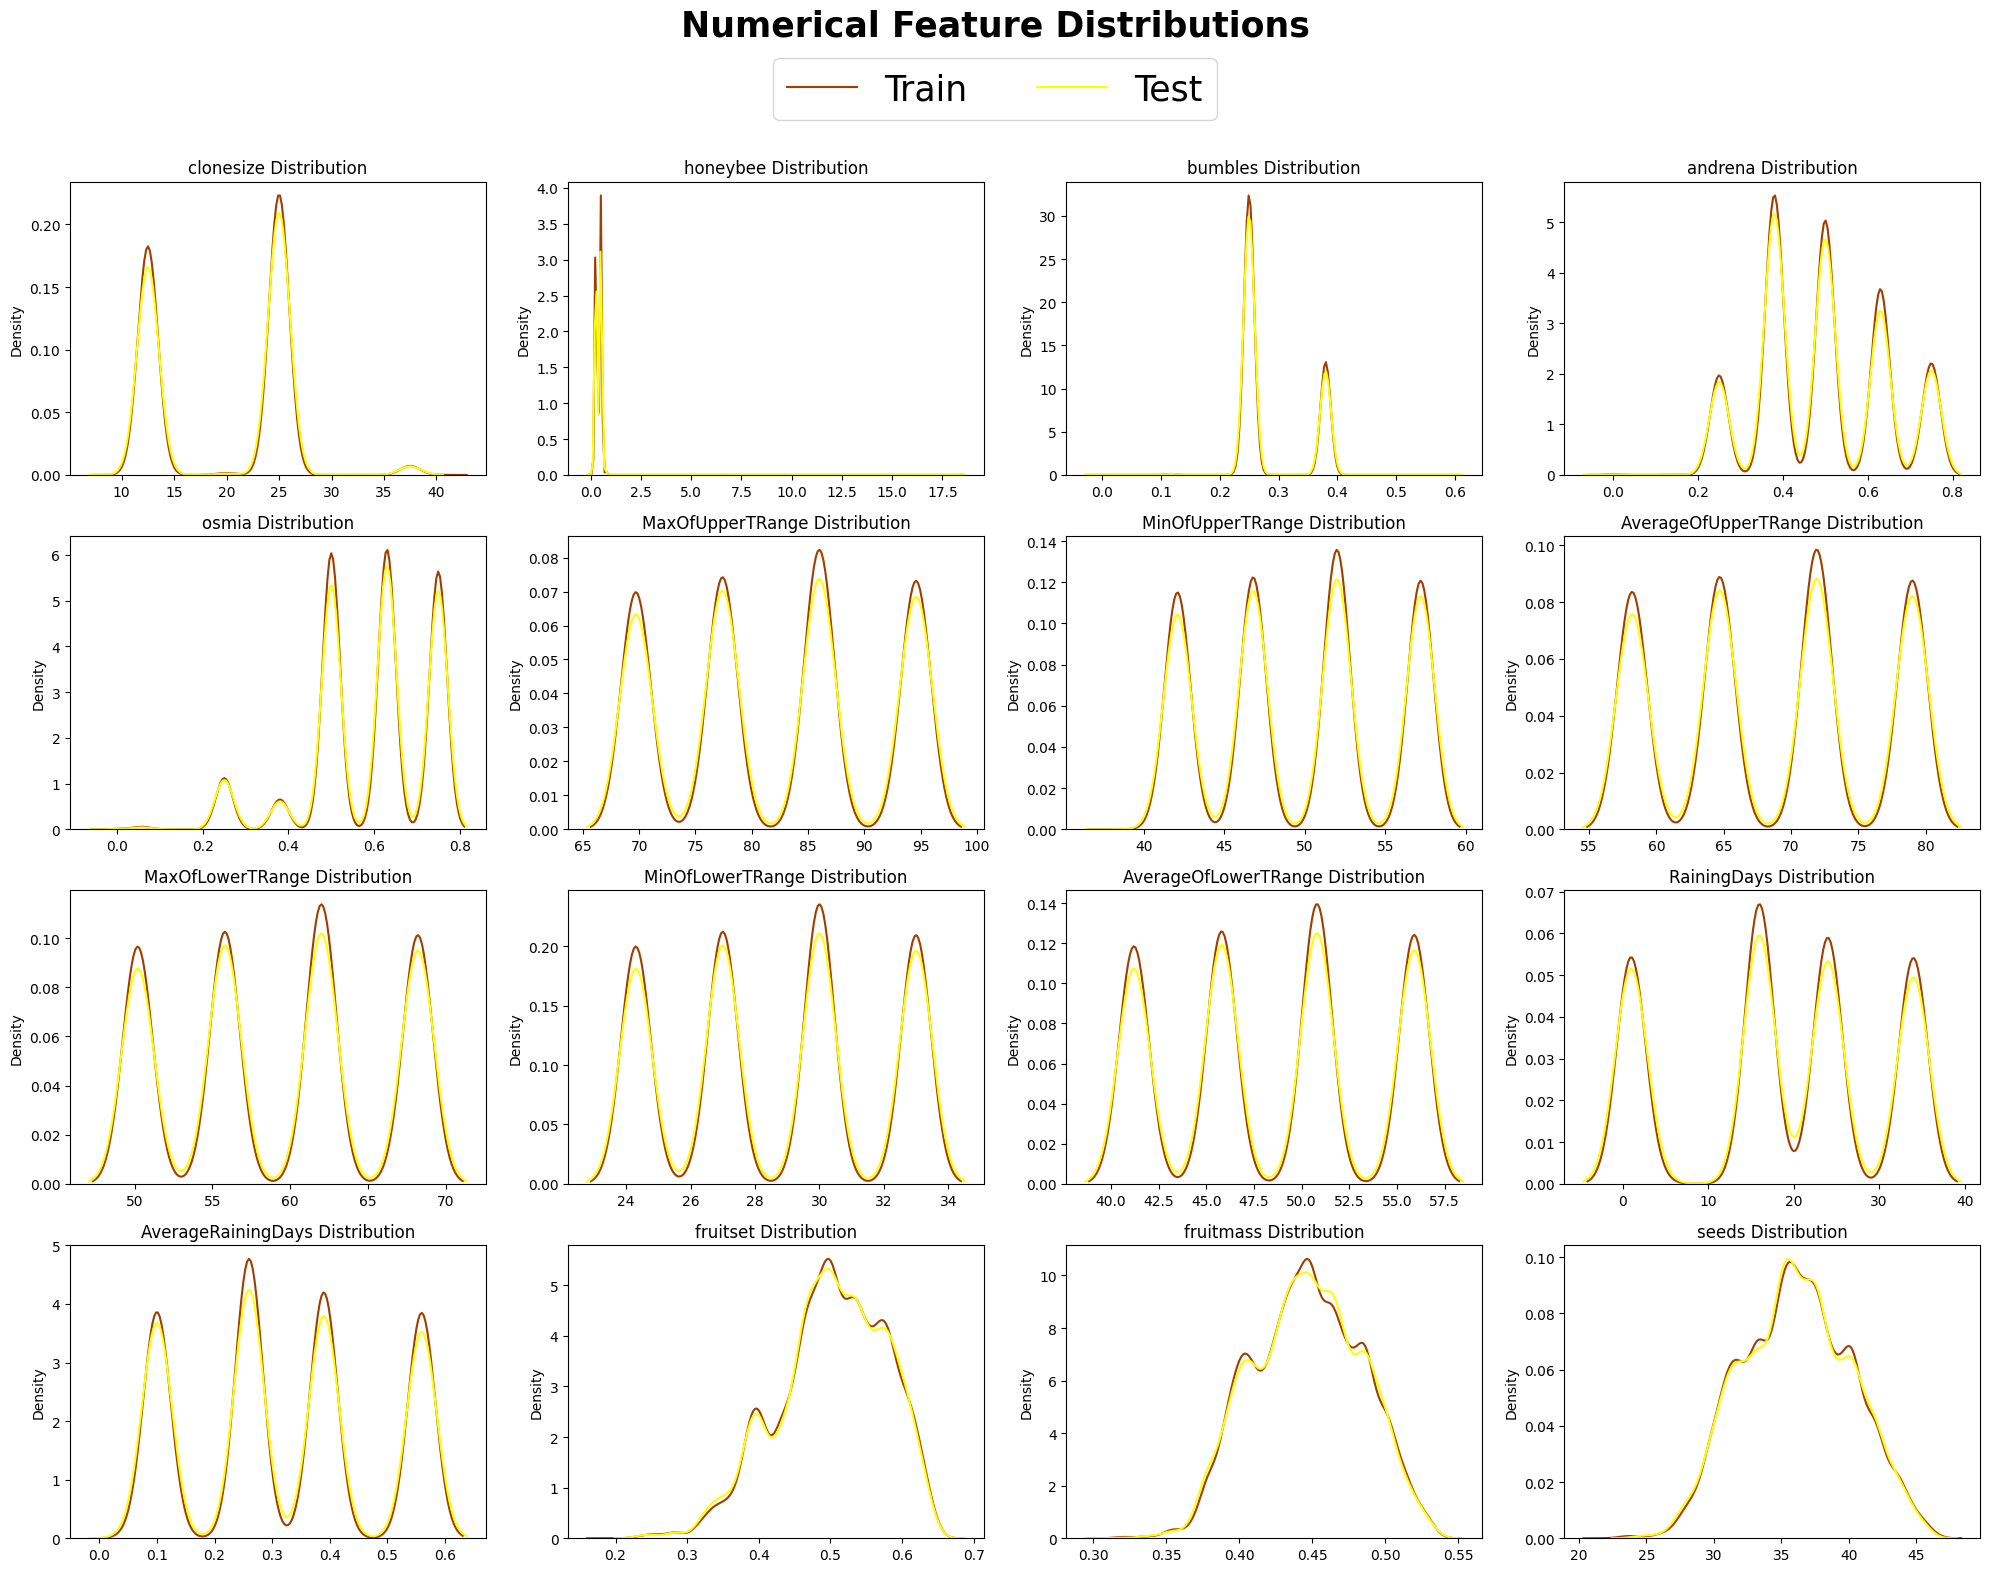

In [79]:
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
#     sns.kdeplot(
#         original[column], label='Original',
#         ax=ax[i], color='#20BEFF'
#     )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()


💡 Insights:

Distiribution between train and test dataset is almost the same.

As all variables are numerical, you need to scale it if you want to use linear methods.

## HeatMap

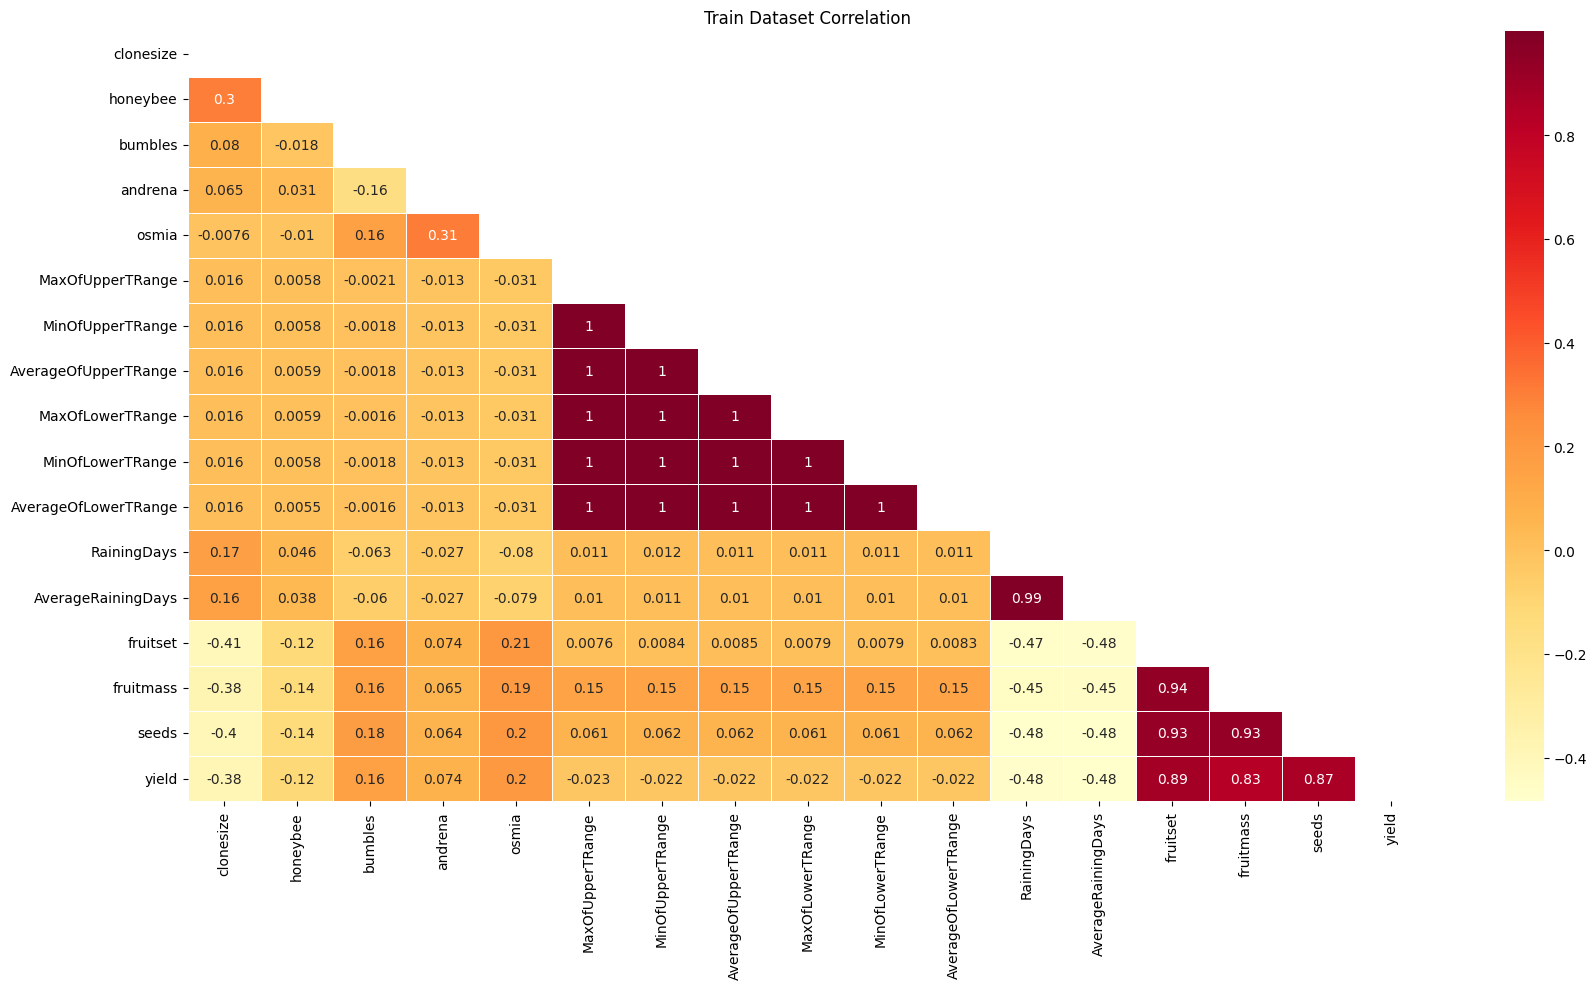

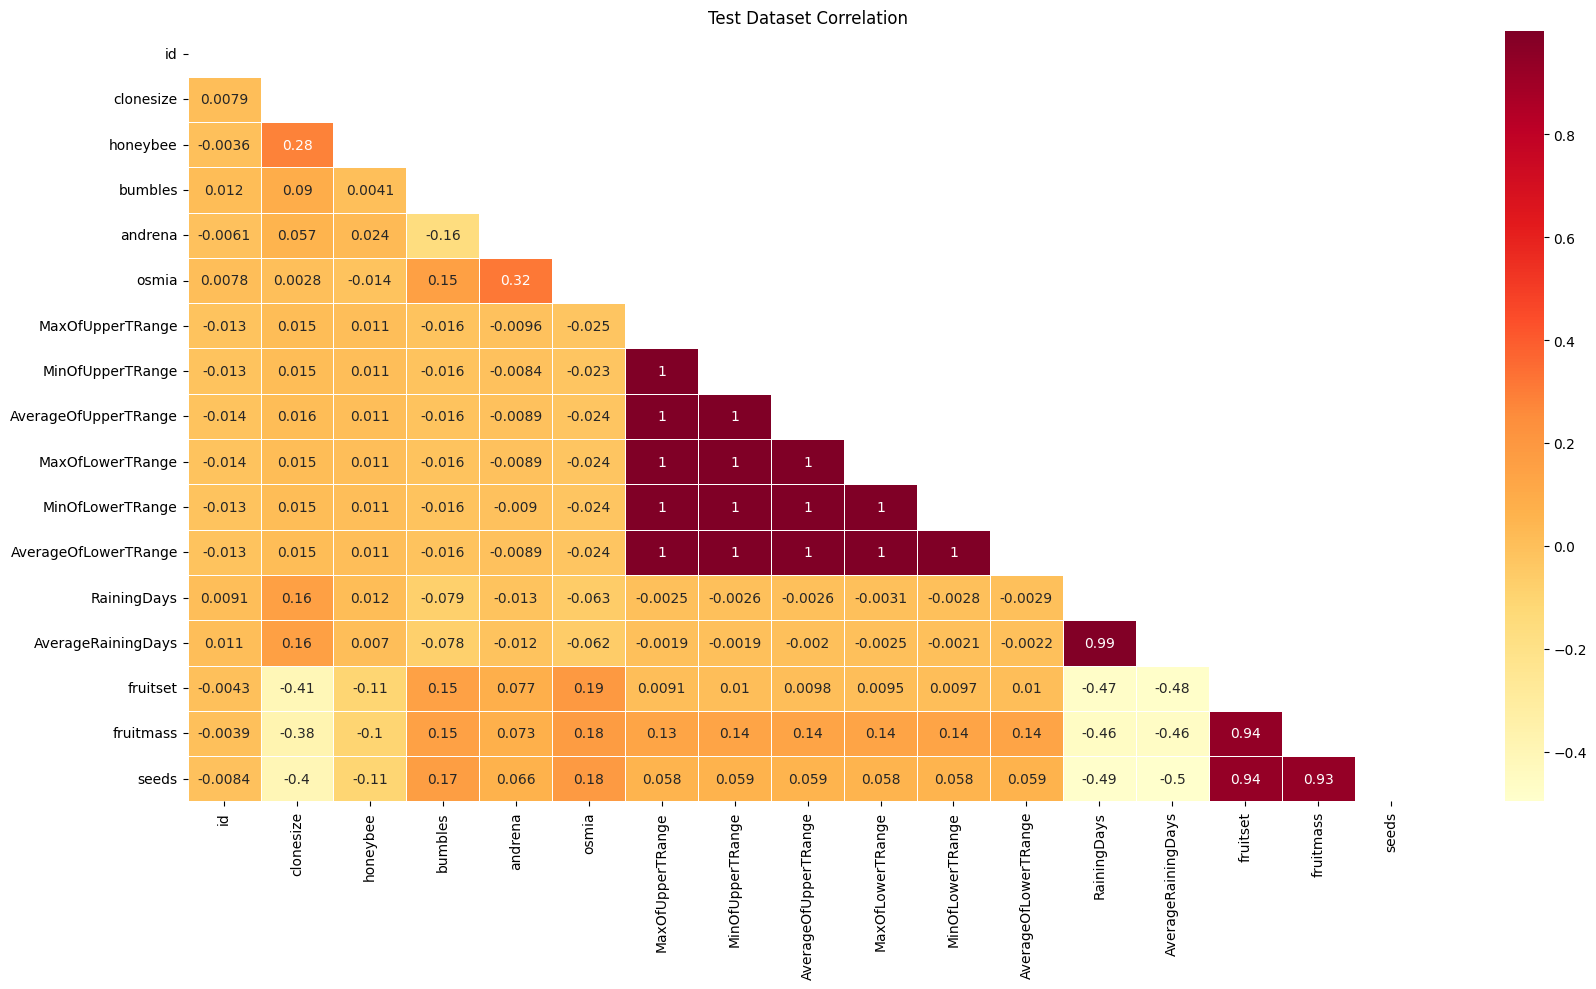

In [80]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')

💡 Insights:

TRange variables are highly correlated.

fruitmass and fruitset , fruitmass and seed are highly correlated with each other.

In [81]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [91]:



X_train = train.drop(columns="yield")
y_train = train["yield"]
     

In [64]:

!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
df2.set_index('id',inplace=True)

XGBoost is an efficient implementation of gradient boosting that can be used for regression predictive modeling. How to evaluate an XGBoost regression model using the best practice technique of repeated k-fold cross-validation. How to fit a final model and use it to make a prediction on new data.

In [97]:
from xgboost import XGBRegressor


xgb = XGBRegressor(n_estimators=100,learning_rate= 0.1,max_depth=3,subsample= 0.5,seed=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [98]:
X_test = df2
     

In [99]:

pred = xgb.predict(X_test)

In [100]:

pred

array([4214.997 , 6079.1787, 7153.144 , ..., 6524.929 , 4424.32  ,
       7247.6177], dtype=float32)

In [105]:

submission = pd.DataFrame({'id':X_test.index, 'yield': pred})
submission

,id,yield
0,15289,4214.997070
1,15290,6079.178711
2,15291,7153.144043
3,15292,4663.031250
4,15293,3885.064209
...,...,...
10189,25478,5410.045410
10190,25479,5688.958496
10191,25480,6524.929199
10192,25481,4424.319824


Evaluation
Submissions will be evaluated using Mean Absolute Error (MAE),

MAE

where each x_i represents the predicted target, y_i represents the ground truth, and n is the number of rows in the test set.

In [106]:

submission.to_csv('submission.csv')